In [1]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 723 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.7 MB/s 
     |████████████████████████████████| 168 kB 26.9 MB/s 
     |████████████████████████████████| 182 kB 8.8 MB/s 
     |████████████████████████████████| 62 kB 636 kB/s 
     |████████████████████████████████| 140 kB 66.3 MB/s 


In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [4]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Training Config
config = {
    "batch_size" : 8,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 126,
    "feature_dim" : 1,
    "hidden_dim" : 64,
    "output_dim" : 1,
    "num_layers" : 3,
    "dropout" : 0.2
}

In [6]:
# load all that we need
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Log Adj Close', 'Log Return', 10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * 100
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        return data
    
    def prepare_data(self, data):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization
        """
        vol_10 = data['10-day-vol'].values
        dataset = vol_10.reshape(-1, 1)[11:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
dataset, scaler = volatiltiy_data.prepare_data(data)
print(np.shape(dataset))

[*********************100%***********************]  1 of 1 completed
(8290, 1)


In [7]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, -1))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.dataset[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps].view(self.batch_size, time_steps, self.feature_size)
            label = y[:, index+time_steps].view(self.batch_size, self.feature_size)
            index += 1
            yield input, label

In [8]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, batch_size=config["batch_size"], sequence_length=config["look_back"])
tmp = iter(dataloader)
input, label = next(tmp)
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([8, 126, 1])
label shape = torch.Size([8, 1])


In [9]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], dropout=config["dropout"], batch_first=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)

    def forward(self, x):
        x, h = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [10]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([8, 1])
shape of label : torch.Size([8, 1])
         Kernel Shape  Output Shape   Params Mult-Adds
Layer                                                 
0_lstm              -  [8, 126, 64]  83.712k   82.176k
1_relu              -       [8, 64]        -         -
2_linear      [64, 1]        [8, 1]     65.0      64.0
-------------------------------------------------------
                       Totals
Total params          83.777k
Trainable params      83.777k
Non-trainable params      0.0
Mult-Adds              82.24k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[8, 126, 64]",83712.0,82176.0
1_relu,-,"[8, 64]",NaN,NaN
2_linear,"[64, 1]","[8, 1]",65.0,64.0


In [11]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, batch_size=4, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [12]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction.flatten(), target.flatten())

        val_loss += loss.item()
        # print(loss.item())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target

    batch_bar.close()
    val_loss /= len(dataloader)

    return val_loss

In [13]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [14]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_lookback", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: quantoalpha. Use `wandb login --relogin` to force relogin


In [15]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_bidrectional'
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler': scheduler_lr.state_dict(),
                    'val_loss': val_loss, 
                    'epoch': epoch}, path)
wandb.save(path)
run.finish()


Epoch 1/20: 
	 Train Loss 0.0029565	 Eval Loss 0.0050018	 Learning Rate 0.0010	



Epoch 2/20: 
	 Train Loss 0.0022504	 Eval Loss 0.0047883	 Learning Rate 0.0010	



Epoch 3/20: 
	 Train Loss 0.0023004	 Eval Loss 0.0047834	 Learning Rate 0.0010	



Epoch 4/20: 
	 Train Loss 0.0022731	 Eval Loss 0.0048205	 Learning Rate 0.0010	


Epoch 00005: reducing learning rate of group 0 to 7.5000e-04.

Epoch 5/20: 
	 Train Loss 0.0025385	 Eval Loss 0.0060925	 Learning Rate 0.0010	



Epoch 6/20: 
	 Train Loss 0.0030892	 Eval Loss 0.0063668	 Learning Rate 0.0008	



Epoch 7/20: 
	 Train Loss 0.0030286	 Eval Loss 0.0061193	 Learning Rate 0.0008	


Epoch 00008: reducing learning rate of group 0 to 5.6250e-04.

Epoch 8/20: 
	 Train Loss 0.0031701	 Eval Loss 0.0064127	 Learning Rate 0.0008	



Epoch 9/20: 
	 Train Loss 0.0030765	 Eval Loss 0.0063886	 Learning Rate 0.0006	



Epoch 10/20: 
	 Train Loss 0.0024714	 Eval Loss 0.0053595	 Learning Rate 0.0006	


Epoch 00011: reducing learning rate of group 0 to 4.2188e-04.

Epoch 11/20: 
	 Train Loss 0.0023071	 Eval Loss 0.0058912	 Learning Rate 0.0006	



Epoch 12/20: 
	 Train Loss 0.0023599	 Eval Loss 0.0058883	 Learning Rate 0.0004	



Epoch 13/20: 
	 Train Loss 0.0021533	 Eval Loss 0.0057540	 Learning Rate 0.0004	



Epoch 14/20: 
	 Train Loss 0.0021933	 Eval Loss 0.0055566	 Learning Rate 0.0004	



Epoch 15/20: 
	 Train Loss 0.0025783	 Eval Loss 0.0048582	 Learning Rate 0.0004	



Epoch 16/20: 
	 Train Loss 0.0020836	 Eval Loss 0.0052661	 Learning Rate 0.0004	



Epoch 17/20: 
	 Train Loss 0.0020681	 Eval Loss 0.0054385	 Learning Rate 0.0004	



Epoch 18/20: 
	 Train Loss 0.0020331	 Eval Loss 0.0056910	 Learning Rate 0.0004	



Epoch 19/20: 
	 Train Loss 0.0020727	 Eval Loss 0.0055151	 Learning Rate 0.0004	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")



Epoch 20/20: 
	 Train Loss 0.0020211	 Eval Loss 0.0058533	 Learning Rate 0.0004	


learning_Rate,█████▅▅▅▃▃▃▁▁▁▁▁▁▁▁▁
train_loss,▇▂▃▃▄█▇█▇▄▃▃▂▂▄▁▁▁▁▁
val_loss,▂▁▁▁▇█▇██▃▆▆▅▄▁▃▄▅▄▆
learning_Rate,0.00042
train_loss,0.00202
val_loss,0.00585


In [17]:
# Prediction (test data)
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        test_loss += criterion(prediction.flatten(), target.flatten())

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target

    test_loss /= len(test_loader)
    print(f'target : {preds}')
    print(f'predict : {targets}')

    return preds, targets, test_loss

In [18]:
torch.cuda.empty_cache()
gc.collect()

preds, targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

target : [0.066199854, 0.06466927, 0.06395081, 0.063515596, 0.06334973, 0.06332303, 0.06336557, 0.063425, 0.06347872, 0.063524954, 0.0635645, 0.06362471, 0.06367576, 0.06371963, 0.06375886, 0.06378453, 0.063791364, 0.06382228, 0.06386064, 0.06390747, 0.06397089, 0.06403166, 0.06409403, 0.06414829, 0.06419723, 0.06424114, 0.06427988, 0.064300954, 0.06431382, 0.064323954, 0.06431163, 0.06429997, 0.06429431, 0.06428973, 0.06428846, 0.064296864, 0.064306, 0.06431836, 0.06433275, 0.064341255, 0.064385764, 0.064459994, 0.06454259, 0.06463306, 0.06473226, 0.06483583, 0.0649562, 0.06509221, 0.06523256, 0.065368675, 0.065492995, 0.06560949, 0.06571312, 0.06579355, 0.06588403, 0.065966815, 0.06603795, 0.06609351, 0.06613821, 0.066168174, 0.06619173, 0.06620946, 0.066222064, 0.0662324, 0.066238314, 0.06624219, 0.06624539, 0.06624833, 0.06625068, 0.06625266, 0.06625411, 0.0662553, 0.066256516, 0.06625627, 0.066254884, 0.06625368, 0.06625284, 0.06625232, 0.066252075, 0.06625199, 0.06625186, 0.06625

In [19]:
criterion(torch.from_numpy(np.array(preds)), torch.from_numpy(np.array(targets)))

print(torch.std(torch.from_numpy(np.array(preds))))
print(torch.std(torch.from_numpy(np.array(targets))))

tensor(0.0234)
tensor(0.0953)


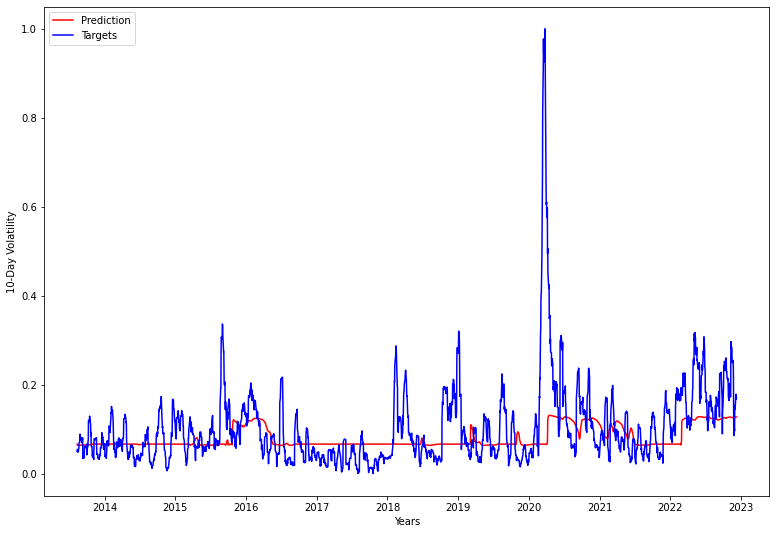

In [20]:
df = data.copy()
df = df.tail(len(preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = preds

# Generate output
plt.figure(figsize=(13,9))
plt.plot(df.index, preds, label="Prediction", color="red")
plt.plot(df.index, targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

target : [0.06551962, 0.06558608, 0.06558543, 0.06559432, 0.06569041, 0.06579456, 0.065825716, 0.06575598, 0.065657385, 0.06556308, 0.0655147, 0.06540591, 0.06529854, 0.06524005, 0.06546139, 0.06572631, 0.06599585, 0.06631674, 0.067501195, 0.06956618, 0.07191918, 0.07525624, 0.08409651, 0.09247614, 0.09676161, 0.100517005, 0.10408621, 0.10735437, 0.110236906, 0.11395682, 0.116979405, 0.119315244, 0.120939374, 0.12221174, 0.123234674, 0.1238503, 0.12429832, 0.12416454, 0.12410881, 0.12350288, 0.123026036, 0.122656494, 0.122107506, 0.12141965, 0.12077452, 0.12012473, 0.119618624, 0.11889411, 0.11859731, 0.118653774, 0.11864257, 0.118619576, 0.11905195, 0.12015928, 0.1210874, 0.12187885, 0.12239447, 0.122825034, 0.12289733, 0.123338535, 0.12376574, 0.12415257, 0.124443516, 0.12431346, 0.12426687, 0.12422559, 0.1245064, 0.12492447, 0.12524414, 0.12521765, 0.12506665, 0.12482269, 0.124786176, 0.12475781, 0.12464927, 0.12455969, 0.12425622, 0.12385106, 0.123519436, 0.123251215, 0.123209625, 

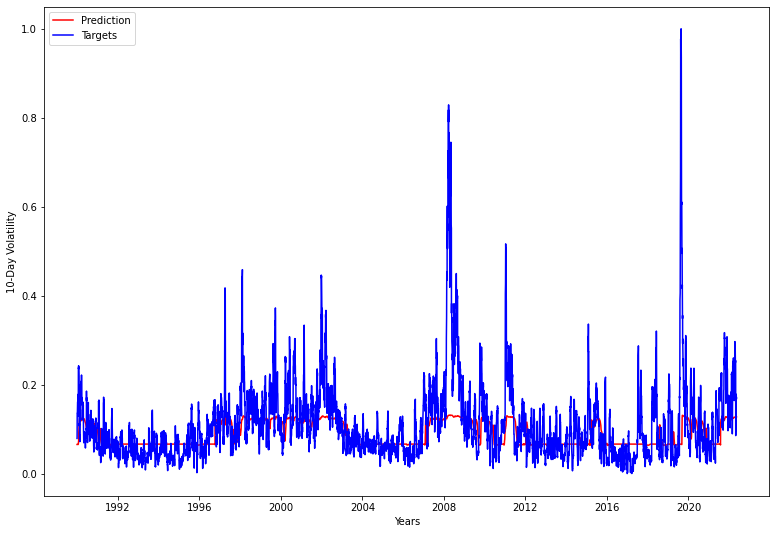

In [21]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, test_loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)